<a href="https://colab.research.google.com/github/kkarolina71/ML_2024/blob/main/Przyk%C5%82ad_strategii_AMZN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Strategia inwestycyjna (decyzje wejścia i wyjścia) dla spółki  Amazon (AMZN),

test w okresie od 01.01.2024 - 06.05.2024



Stwórz model generujący sygnały kupna i sprzedaży na rynku

Decyzje ma generować jeden z algorytmów uczenia maszynowego, po optymalizacji hiperparametrów

Zrób backtest wybranego modelu, użyj biblioteki przystosowanej do backtestów

Pamiętaj o wnioskach i wizualizacji wyników

4 pkt z oceny będą zależne od wyników inwestycji

Inwestujesz w wylosowaną spółkę przez określony okres, ale można wykorzystać także inne dane niż historyczne (np. obliczone wskaźniki)


In [4]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29411 sha256=3e650b03daa86e3eb5266773f0239aae55c492f44f1ab304b7344c81e360051b
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [6]:
!pip install backtesting

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.5/175.5 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for backtesting: filename=Backtesting-0.3.3-py3-none-any.whl size=173916 sha256=ad0288461640dad3492edb98072fd7d7f7e28f9932da80351b2a6d83efc28218
  Stored in directory: /root/.cache/pip/wheels/e2/30/7f/19cbe31987c6ebdb47f1f510343249066711609e3da2d57176
Successfully built backtesting


In [25]:
!pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 2.7 MB/s eta 0:00:00


In [7]:
# import ffn # http://pmorissette.github.io/ffn/index.html

import yfinance as yf
import datetime as dt

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from ta.trend import MACD
import ta

from backtesting.lib import SignalStrategy, TrailingStrategy
from backtesting import *


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam


#### Pobranie szeregu czasowego

In [8]:
start_date = dt.datetime(2019,1,1) # (RRR-MM-DD)
end_date = dt.datetime(2024,5,6)

company = 'AMZN'

data = yf.download(company,start_date, end_date)

[*********************100%%**********************]  1 of 1 completed


In [9]:
data.describe().round(2)

,Open,High,Low,Close,Adj Close,Volume
count,1344.00,1344.00,1344.00,1344.00,1344.00,1.344000e+03
mean,130.45,132.03,128.79,130.43,130.43,7.375730e+07
std,32.23,32.50,31.87,32.14,32.14,3.354315e+07
min,73.26,76.90,73.05,75.01,75.01,1.762600e+07
25%,96.65,97.74,95.34,96.61,96.61,5.150150e+07
50%,130.96,132.41,128.95,130.57,130.57,6.434465e+07
75%,160.23,161.81,158.34,160.16,160.16,8.687058e+07
max,187.72,189.77,185.51,189.05,189.05,3.113460e+08


Spółka nie wypłacała dywidendy, więc można użyć 'Close' lub 'Adj Close'.

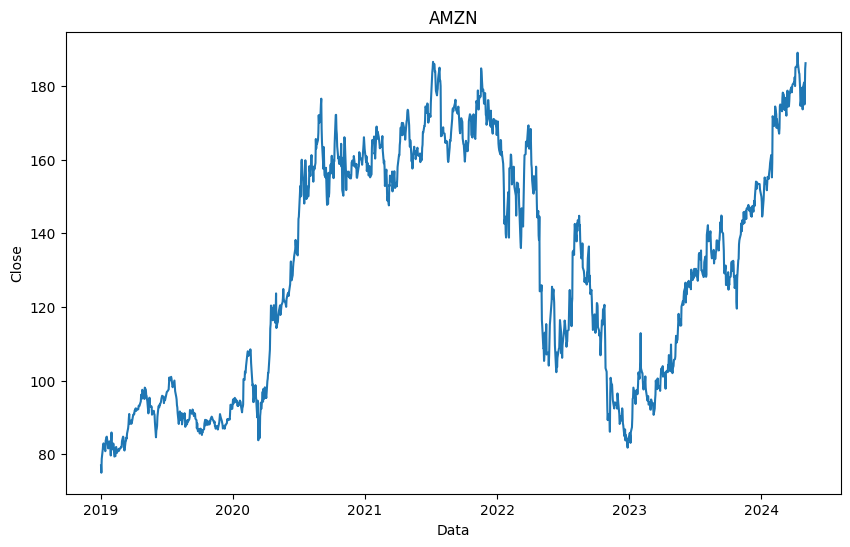

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(data['Close'])
plt.xlabel('Data')
plt.ylabel('Close')
plt.title(company)
plt.show()

### Dane testowe

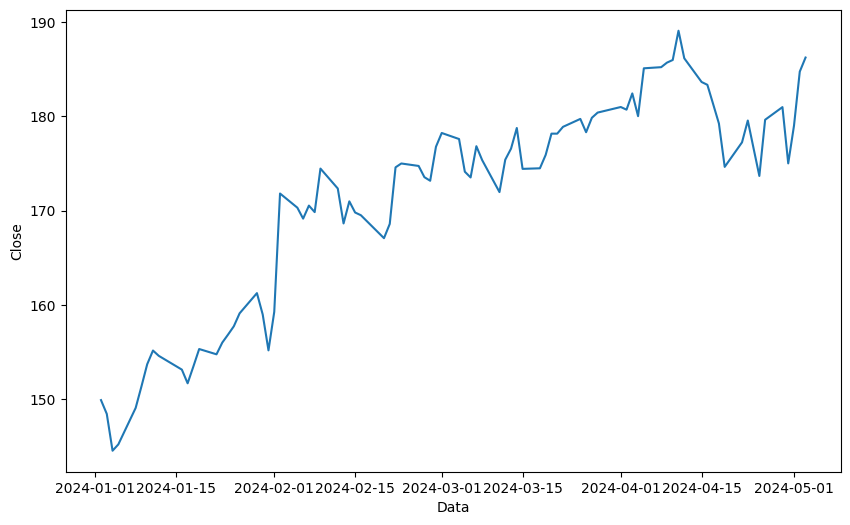

In [11]:
test_start = dt.datetime(2024,1,1) # (RRR-MM-DD)
test_end = dt.datetime(2024,5,6)

test_data = data.loc[(data.index >= test_start) & (data.index <= test_end)]
plt.figure(figsize=(10, 6))
plt.plot(test_data['Close'])
plt.xlabel('Data')
plt.ylabel('Close')
plt.show()

## Dane treningowe


Muszę dopytać czy obliczanie wskaźników może być na pełnym zakresie danych czy oddzielnie dla okresu testowego. Tutaj w przykładzie zrobione jest łącznie, to znaczy, że do wyliczenia wskaźników brany jest cały okres łącznie z testowym.

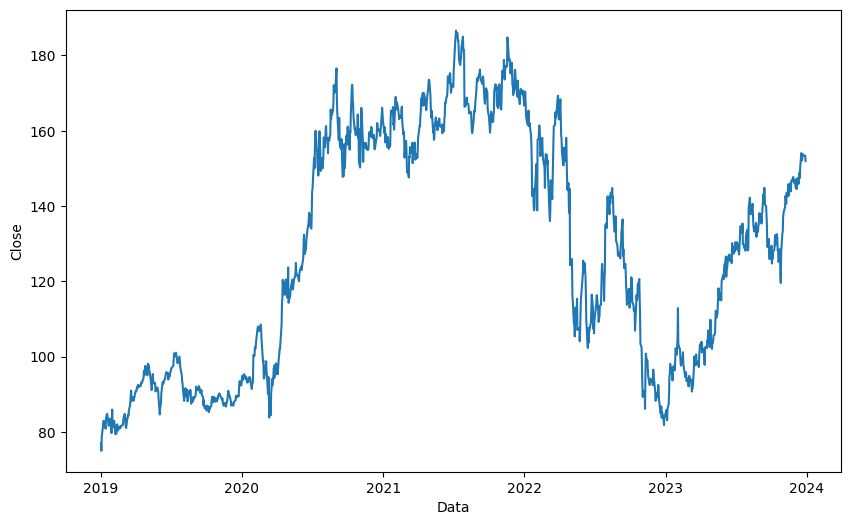

In [12]:
train_start = dt.datetime(2019,1,1)
train_end = dt.datetime(2024,1,1)

train_data = data.loc[(data.index >= train_start) & (data.index <= train_end)]
plt.figure(figsize=(10, 6))
plt.plot(train_data['Close'])
plt.xlabel('Data')
plt.ylabel('Close')
plt.show()

### Zwroty
Używam zwrotów logarytmicznych, ponieważ są bardziej odporne na wahanai i wartości odstające.

In [13]:
data['returns'] = data['Close'].to_log_returns()
data = data.dropna()

AttributeError: 'Series' object has no attribute 'to_log_returns'

In [ ]:
# rozkład zwrotów logarytmicznych
ax = data['returns'].hist(figsize=(8, 4))

#### Porównanie z indeksem NASDAQ (^IXIC)

Sprawdzenie korelacji pomiędzy spółką a głównym indeksem giełdowym

In [ ]:
df = ffn.get('^IXIC:Close, AMZN:Close', start=train_start, end=train_end)

In [ ]:
returns = df.to_log_returns().dropna()
print(returns.head())

In [ ]:
# porównanie zwrotów
ax2 = returns.hist(figsize=(12, 5))

In [ ]:
returns.corr().as_format('.2f')

In [ ]:
df.rebase().plot(figsize=(12,5))

Widać wysoką korelację pomiędzy szeregami

### Mozna to pominąć ----------

Sprawdzam zwroty mesięczne dla indeksu i spółki oraz roczny zwrot

In [ ]:
perf['ixicclose'].display_monthly_returns()

In [ ]:
perf['amznclose'].display_monthly_returns()

Można poszukać prawidłowości ale okres obejmuje covid, więc nie wiem czy jest sens.

### Przyczynowość w sensie Grangera

In [14]:
# my_data = pd.DataFrame({'NASDAQ': returns['ixicclose'], 'AMZN': returns['amznclose']})

# # Wybór modelu VAR
# model = VAR(my_data)
# results = model.fit(maxlags=1, ic='aic')

# print(results.summary())

# # Test Ljung-Boxa
# ljung_box_nasdaq = acorr_ljungbox(results.resid['NASDAQ'])
# print(f"Ljung-Box test for NASDAQ: {ljung_box_gold}")

# ljung_box_amazn = acorr_ljungbox(results.resid['AMZN'])
# print(f"Ljung-Box test for AMZN: {ljung_box_silver}")

# # Test stabilności
# stability_test = results.test_causality('NASDAQ', 'AMZN', kind='f')
# print(stability_test.summary())

# stability_test_2 = results.test_causality('AMZN', 'NASDAQ', kind='f')
# print(stability_test_2.summary())

L1.NASDAQ: -0.207284 (p = 0.001) - opóźniona wartość NASDAQ ma negatywny i statystycznie istotny wpływ na bieżącą wartość AMZN.

### ------- Koniec pominięcia

## Podział na dane testowe i treningowe
#### Przygotowanie danych pod deep learning
Można zastosowac różne modele. Ja wybrałam sobie LSTM (testowałam xgboost ale słaby)

In [15]:
# Wybór danych testowych i treningowych
train_data = data[(data.index >= train_start) & (data.index <= train_end)]
test_data = data[(data.index >= test_start) & (data.index <= test_end)]

# Przygotowanie danych
prices_train = train_data["Close"].values.reshape(-1, 1)  # konwersja do tablicy numpy
prices_test = test_data["Close"].values.reshape(-1, 1)

# Przeskalowanie do zakresu [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices_train = scaler.fit_transform(prices_train)
scaled_prices_test = scaler.transform(prices_test)

# Tworzenie sekwencji danych dla modelu LSTM
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Określenie długości sekwencji (liczba kroków wstecznych)
sequence_length = 10 # ile dni bierzemy pod uwagę do predykcji

# Utworzenie sekwencji danych treningowych i testowych
X_train, y_train = create_sequences(scaled_prices_train, sequence_length)
X_test, y_test = create_sequences(scaled_prices_test, sequence_length)

print("Rozmiar danych treningowych:", X_train.shape, y_train.shape)
print("Rozmiar danych testowych:", X_test.shape, y_test.shape)

Rozmiar danych treningowych: (1248, 10, 1) (1248, 1)
Rozmiar danych testowych: (76, 10, 1) (76, 1)


## LSTM

In [16]:
# Model LSTM z hiperparametryzacją
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, input_shape=input_shape, return_sequences=True))
    model.add(LSTM(units=50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

input_shape = (X_train.shape[1], X_train.shape[2])  # Kształt danych wejściowych dla modelu LSTM
lstm_model = create_lstm_model(input_shape)

# Trenowanie
lstm_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Predykcja cen dla danych testowych
predicted_prices = lstm_model.predict(X_test)


Epoch 1/100
32/32 [==============================] - 6s 43ms/step - loss: 0.0378 - val_loss: 0.0020
Epoch 2/100
32/32 [==============================] - 1s 22ms/step - loss: 0.0037 - val_loss: 0.0016
Epoch 3/100
32/32 [==============================] - 1s 21ms/step - loss: 0.0028 - val_loss: 0.0017
Epoch 4/100
32/32 [==============================] - 1s 21ms/step - loss: 0.0028 - val_loss: 0.0017
Epoch 5/100
32/32 [==============================] - 1s 23ms/step - loss: 0.0028 - val_loss: 0.0016
Epoch 6/100
32/32 [==============================] - 1s 23ms/step - loss: 0.0028 - val_loss: 0.0017
Epoch 7/100
32/32 [==============================] - 1s 16ms/step - loss: 0.0027 - val_loss: 0.0016
Epoch 8/100
32/32 [==============================] - 0s 14ms/step - loss: 0.0027 - val_loss: 0.0018
Epoch 9/100
32/32 [==============================] - 0s 14ms/step - loss: 0.0027 - val_loss: 0.0018
Epoch 10/100
32/32 [==============================] - 0s 15ms/step - loss: 0.0026 - val_loss: 0.0016

In [17]:
mse = mean_squared_error(y_test, predicted_prices)
print("Mean Squared Error (MSE) na danych testowych:", mse.round(5))

Mean Squared Error (MSE) na danych testowych: 0.00096


In [18]:
predicted_prices_unscaled = scaler.inverse_transform(predicted_prices)

In [21]:
# Dodanie przewidywanych cen do testowych danych
test_data['Predicted_Close'] = np.nan
test_data['Predicted_Close'].iloc[sequence_length:] = predicted_prices_unscaled.flatten()

## 3 sposoby tworzenia sygnałów:


<img src="https://media.giphy.com/media/v1.Y2lkPTc5MGI3NjExejZ5MHlxcG80ZnpxcHdqc2I2a3VoYWxjcm8xdDdneXp2bWYzMm1xeiZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/L3c8aAACw7Qpx2ojGB/giphy.gif" width="400" align="center">



Na samych predykcjach modelu LSTM najlepiej wypada opcja 3
### 1.

Najmniej 'realna'

Jeśli przewidywana cena jest wyższa niż rzeczywista cena zamknięcia, generowany jest sygnał kupna (1). W przeciwnym razie generowany jest sygnał sprzedaży (-1)

In [20]:
# Tworzenie sygnałów
test_data['Signal'] = 0
test_data['Signal'][sequence_length:] = np.where(test_data['Predicted_Close'][sequence_length:] > test_data['Close'][sequence_length:], 1, -1)


### 2.
Porównujemy predykcję na jutro z dzisiejszą ceną zamknięcia

Jeśli tomorrow_predicted_close > today_close, ustawiamy test_data['Signal'].iloc[i + 1] = 1 (sygnał kupna).

Jeśli tomorrow_predicted_close < today_close, ustawiamy test_data['Signal'].iloc[i + 1] = -1 (sygnał sprzedaży).

W przeciwnym razie, test_data['Signal'].iloc[i + 1] = 0 (brak zmiany).

In [ ]:
test_data['Signal'] = 0

for i in range(sequence_length, len(test_data) - 1):
    today_close = test_data['Close'].iloc[i]
    tomorrow_predicted_close = test_data['Predicted_Close'].iloc[i + 1]

    if tomorrow_predicted_close > today_close:
        test_data['Signal'].iloc[i + 1] = 1  # Kup
    elif tomorrow_predicted_close < today_close:
        test_data['Signal'].iloc[i + 1] = -1  # Sprzedaj
    else:
        test_data['Signal'].iloc[i + 1] = 0  # Brak zmiany


### 3. To samo co 2. tylko porównanie ceny dzisiaj z predykcją za 5 dni (można dowolną liczbe wstawić)

In [22]:
test_data['Signal'] = 0

# Przewidywane ceny zamknięcia za 5 dni
future_predicted_close = test_data['Predicted_Close'].shift(-5)

for i in range(sequence_length, len(test_data) - 5):  # zmiana z len(test_data) - 1 na len(test_data) - 5
    today_close = test_data['Close'].iloc[i]
    tomorrow_predicted_close = future_predicted_close.iloc[i]

    if tomorrow_predicted_close > today_close:
        test_data['Signal'].iloc[i + 5] = 1  # Kup
    elif tomorrow_predicted_close < today_close:
        test_data['Signal'].iloc[i + 5] = -1  # Sprzedaj
    else:
        test_data['Signal'].iloc[i + 5] = 0  # Brak zmiany


# Wskaźniki analizy technicznej - można dowolne wybrać z bibliotegi ta

https://technical-analysis-library-in-python.readthedocs.io/en/latest/ta.html#momentum-indicators


Grupy:
![obraz.png](attachment:obraz.png)

<img src="https://media.giphy.com/media/v1.Y2lkPTc5MGI3NjExc2U1a3ZkdTFjaWFkOXc0dGl2bTQ3dHI1b2xwNG9kcnhxNG03d2M5OCZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/3diE2vbIarCXWXaN15/giphy.gif" width="400" align="center">


Wskaźniki liczę na testowym dataframe ze względu małą liczbę danych testowych <- jeszcze muszę się dopytać

### MACD
przykład

In [23]:
macd_indicator = ta.trend.MACD(test_data['Close'])

# Łączenie z ramką danych
test_data['macd'] = macd_indicator.macd()
test_data['macd_signal'] = macd_indicator.macd_signal()

# Różnica potrzebna do sygnałów
test_data['macd_diff'] = test_data['macd'] - test_data['macd_signal']

# Domyśnie HOLD
test_data['signal_MACD'] = 0

# Kupno (MACD > sygnał)
test_data.loc[test_data['macd_diff'] > 0, 'signal_MACD'] = 1

# Sprzedaż (MACD < sygnał)
test_data.loc[test_data['macd_diff'] < 0, 'signal_MACD'] = -1


## Strategie

Strategia tylko na predykcjach modelem LSTM:

In [26]:
class LSTMCustomStrategy(SignalStrategy):
    ssl = 0.066975
    ttp = 0.060409
    size_tr = 0.878244
    def init(self):
        super().init()
        self.signal = self.I(lambda x: test_data['Signal'], 'signal')

    def next(self):
        close = self.data.Close
        signal = self.signal
        upper_tp = close * (1 + self.ttp)
        upper_sl = close * (1 + self.ssl)
        lower_sl = close * (1 - self.ssl)
        lower_tp = close * (1 - self.ttp)

        if signal == 1 and not self.position.is_long:
            self.buy(size=self.size_tr, sl=lower_sl, tp=upper_tp)
        elif signal == -1 and not self.position.is_short:
            self.sell(size=self.size_tr, sl=upper_sl, tp=lower_tp)

bt = Backtest(test_data, LSTMCustomStrategy, cash=10000, commission=0.002, trade_on_close=False, hedging=False)
stats = bt.run()
bt.plot()
print(stats)

# Optymalizacja parametrów
stats_skopt, heatmap, optimize_result = bt.optimize(
    ttp=[0.01, 0.1],
    ssl=[0.01, 0.1],
    size_tr=[0.4, 1],
    maximize='Equity Final [$]',
    method='skopt',
    max_tries=1000,
    random_state=10,
    return_heatmap=True,
    return_optimization=True
)
heatmap.sort_values().iloc[-3:]


Start                     2024-01-02 00:00:00
End                       2024-05-03 00:00:00
Duration                    122 days 00:00:00
Exposure Time [%]                   81.395349
Equity Final [$]                 10571.323723
Equity Peak [$]                  11076.988923
Return [%]                           5.713237
Buy & Hold Return [%]                24.19797
Return (Ann.) [%]                   17.680545
Volatility (Ann.) [%]                17.37705
Sharpe Ratio                         1.017465
Sortino Ratio                        2.159308
Calmar Ratio                         3.873061
Max. Drawdown [%]                   -4.565006
Avg. Drawdown [%]                    -1.88424
Max. Drawdown Duration       59 days 00:00:00
Avg. Drawdown Duration       12 days 00:00:00
# Trades                                   33
Win Rate [%]                        51.515152
Best Trade [%]                       7.583499
Worst Trade [%]                     -5.379489
Avg. Trade [%]                    

Backtest.optimize:   0%|          | 0/1000 [00:00<?, ?it/s]

ttp       ssl       size_tr 
0.023927  0.039880  0.998158    13717.512902
0.023744  0.038651  0.995688    13740.482241
0.023908  0.039133  0.995557    13742.302071
Name: Equity Final [$], dtype: float64

In [27]:
stats_skopt

Start                     2024-01-02 00:00:00
End                       2024-05-03 00:00:00
Duration                    122 days 00:00:00
Exposure Time [%]                   81.395349
Equity Final [$]                 13742.302071
Equity Peak [$]                  13742.302071
Return [%]                          37.423021
Buy & Hold Return [%]                24.19797
Return (Ann.) [%]                  153.832025
Volatility (Ann.) [%]               57.352673
Sharpe Ratio                         2.682212
Sortino Ratio                       14.815229
Calmar Ratio                        30.185432
Max. Drawdown [%]                   -5.096234
Avg. Drawdown [%]                   -1.889251
Max. Drawdown Duration       38 days 00:00:00
Avg. Drawdown Duration        9 days 00:00:00
# Trades                                   25
Win Rate [%]                             60.0
Best Trade [%]                       5.969814
Worst Trade [%]                      -3.19733
Avg. Trade [%]                    

## Strategia z MACD

In [28]:
test_data.head()

,Open,High,Low,Close,Adj Close,Volume,Signal,Predicted_Close,macd,macd_signal,macd_diff,signal_MACD
2024-01-02,151.539993,152.380005,148.389999,149.929993,149.929993,47339400,0,NaN,NaN,NaN,NaN,0
2024-01-03,149.199997,151.050003,148.330002,148.470001,148.470001,49425500,0,NaN,NaN,NaN,NaN,0
2024-01-04,145.589996,147.380005,144.050003,144.570007,144.570007,56039800,0,NaN,NaN,NaN,NaN,0
2024-01-05,144.690002,146.589996,144.529999,145.240005,145.240005,45124800,0,NaN,NaN,NaN,NaN,0
2024-01-08,146.740005,149.399994,146.149994,149.100006,149.100006,46757100,0,NaN,NaN,NaN,NaN,0


In [29]:
class LSTMCustomStrategy(SignalStrategy):
    ssl = 0.066975
    ttp = 0.060409
    size_tr = 0.878244

    def init(self):
        super().init()
        close_series = pd.Series(self.data.Close)  # Convert to Pandas Series
        self.macd_decision = self.I(lambda x: test_data['signal_MACD'], 'signal_MACD')
        self.signal = self.I(lambda x: test_data['Signal'], 'signal')

    def next(self):
        close = self.data.Close
        signal = self.signal
        macd_decision = self.macd_decision
        upper_tp = close * (1 + self.ttp)
        upper_sl = close * (1 + self.ssl)
        lower_sl = close * (1 - self.ssl)
        lower_tp = close * (1 - self.ttp)

        if signal == 1 or macd_decision == 1 and not self.position.is_long:
            self.buy(size=self.size_tr, sl=lower_sl, tp=upper_tp)
        elif signal == -1 or macd_decision == -1 and not self.position.is_short:
            self.sell(size=self.size_tr, sl=upper_sl, tp=lower_tp)

bt = Backtest(test_data, LSTMCustomStrategy, cash=10000, commission=0.002, trade_on_close=False, hedging=False)
stats = bt.run()
bt.plot()
print(stats)

# # Optymalizacja parametrów
stats_skopt, heatmap, optimize_result = bt.optimize(
    ttp=[0.01, 0.1],
    ssl=[0.01, 0.1],
    size_tr=[0.4, 1],
    maximize='Equity Final [$]',
    method='skopt',
    max_tries=1000,
    random_state=10,
    return_heatmap=True,
    return_optimization=True
)
heatmap.sort_values().iloc[-3:]

Start                     2024-01-02 00:00:00
End                       2024-05-03 00:00:00
Duration                    122 days 00:00:00
Exposure Time [%]                   81.395349
Equity Final [$]                  9779.752108
Equity Peak [$]                  12085.974245
Return [%]                          -2.202479
Buy & Hold Return [%]                24.19797
Return (Ann.) [%]                   -6.317528
Volatility (Ann.) [%]               23.959267
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -19.081806
Avg. Drawdown [%]                   -3.197692
Max. Drawdown Duration       22 days 00:00:00
Avg. Drawdown Duration        7 days 00:00:00
# Trades                                   23
Win Rate [%]                        56.521739
Best Trade [%]                       8.737921
Worst Trade [%]                    -10.422409
Avg. Trade [%]                    

Backtest.optimize:   0%|          | 0/1000 [00:00<?, ?it/s]

ttp       ssl       size_tr 
0.099524  0.091207  0.771329    11862.312057
0.099583  0.085866  0.771088    11862.767830
0.099616  0.084285  0.771632    11863.025456
Name: Equity Final [$], dtype: float64

In [30]:
stats_skopt

Start                     2024-01-02 00:00:00
End                       2024-05-03 00:00:00
Duration                    122 days 00:00:00
Exposure Time [%]                   81.395349
Equity Final [$]                 11863.025456
Equity Peak [$]                  12049.350263
Return [%]                          18.630255
Buy & Hold Return [%]                24.19797
Return (Ann.) [%]                   64.971894
Volatility (Ann.) [%]               38.075755
Sharpe Ratio                         1.706385
Sortino Ratio                        5.102277
Calmar Ratio                         8.079642
Max. Drawdown [%]                   -8.041432
Avg. Drawdown [%]                   -2.218682
Max. Drawdown Duration       22 days 00:00:00
Avg. Drawdown Duration        8 days 00:00:00
# Trades                                   27
Win Rate [%]                        66.666667
Best Trade [%]                       9.686225
Worst Trade [%]                     -1.460968
Avg. Trade [%]                    